In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

### You need to get your own license file from Gurobi's website ! It is for single machine use only ! 

In [2]:
import os
import gurobipy as gp

# Set the GRB_LICENSE_FILE environment variable to the correct license file path
os.environ["GRB_LICENSE_FILE"] = "/Users/emrekuru/Developer/Production_Planning/gurobi.lic"

In [3]:
model = gp.Model("PaintingProcessOptimization")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-11


In [4]:
# Parameters
num_parts = 10     # Number of parts
demand = {p: 4 for p in range(1, num_parts + 1)}  

parts_colors = {
    1: 'Red',
    2: 'Blue',
    3: 'Green',
    4: 'Yellow',
    5: 'Black',
    6: 'Red',
    7: 'Blue',
    8: 'Green',
    9: 'Yellow',
    10: 'Black'
}

color_cost = {
    'Red': 5,
    'Blue': 6,
    'Green': 7,
    'Yellow': 10,
    'Black': 9
}

unit_production_time = {
    1: 2,   
    2: 1,   
    3: 1,   
    4: 1,   
    5: 1,   
    6: 1,   
    7: 1,   
    8: 1,   
    9: 1,
    10: 2
}

In [5]:
parts_colors

{1: 'Red',
 2: 'Blue',
 3: 'Green',
 4: 'Yellow',
 5: 'Black',
 6: 'Red',
 7: 'Blue',
 8: 'Green',
 9: 'Yellow',
 10: 'Black'}

In [6]:
# Define continuous variables for start and end times of production for each part
start_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="start_times")
end_times = model.addVars(range(1, num_parts + 1), vtype=GRB.CONTINUOUS, name="end_times")

# Define binary variable to indicate order of parts
order = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), vtype=GRB.BINARY, name="order")
succesor = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), vtype=GRB.BINARY, name="succesor")
color_change = model.addVars(range(1, num_parts + 1), range(1, num_parts + 1), vtype=GRB.BINARY, name="color_change")

In [7]:
model.setObjective(
    quicksum(
        color_cost[parts_colors[p]] * color_change[p, q] for p in range(1, num_parts + 1) for q in range(1, num_parts + 1)
    ),
    GRB.MINIMIZE
)

In [8]:
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            order[p, p_prime].vtype = GRB.BINARY
            
# Ensure each part has at most one immediate successor, with exactly one part having no successor (the end part)
for p in range(1, num_parts + 1):
    model.addConstr(
        quicksum(succesor[p, q] for q in range(1, num_parts + 1) if q != p) <= 1,
        name=f"Single_Successor_{p}"
    )

# Ensure each part has at most one immediate predecessor, with exactly one part having no predecessor (the start part)
for q in range(1, num_parts + 1):
    model.addConstr(
        quicksum(succesor[p, q] for p in range(1, num_parts + 1) if p != q) <= 1,
        name=f"Single_Predecessor_{q}"
    )

# Ensure that there is exactly one part without a successor (the end part)
model.addConstr(
    quicksum(quicksum(succesor[p, q] for q in range(1, num_parts + 1) if q != p) for p in range(1, num_parts + 1)) == num_parts - 1,
    name="Total_Successors"
)


# Ensure mutual exclusivity in ordering between each pair of parts
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            model.addConstr(
                order[p, p_prime] + order[p_prime, p] == 1,
                name=f"Order_Binary_{p}_{p_prime}"
            )

# Link the immediate successor relationship to the order variable
# If part p is the immediate successor of part p_prime, then p_prime should come before p in the order
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            model.addConstr(
                order[p_prime, p] >= succesor[p, p_prime],
                name=f"Order_Successor_Link_{p_prime}_{p}"
            )

# Ensure color change costs are applied when there is a change in color between successive parts
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime and parts_colors[p] != parts_colors[p_prime]:
            model.addConstr(
                color_change[p_prime, p] >= succesor[p, p_prime],
                name=f"Color_Change_{p}_{p_prime}"
            )

# Demand fulfillment constraints to ensure each part meets its demand
for p in range(1, num_parts + 1):
    model.addConstr(
        (end_times[p] - start_times[p]) * unit_production_time[p] >= demand[p],
        name=f"Demand_Fulfillment_{p}"
    )

# No overlap constraints based on the order of parts
# If part p is ordered before part p_prime, then end_times[p] <= start_times[p_prime]
for p in range(1, num_parts + 1):
    for p_prime in range(1, num_parts + 1):
        if p != p_prime:
            model.addConstr(
                end_times[p] <= start_times[p_prime] + (1 - order[p, p_prime]) * 1e6,
                name=f"No_Overlap_{p}_{p_prime}"
            )


In [9]:
# Set model parameters if necessary, e.g., setting the feasibility tolerance
model.setParam("IntFeasTol", 1e-9)

# Optional: Currently going for the optimal solution
# model.setParam("MIPGap", 0.05)       # Accept a solution within 1% of optimal

# Optimize the model
model.optimize()

Set parameter IntFeasTol to value 1e-09
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B83)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 381 rows, 320 columns and 1080 nonzeros
Model fingerprint: 0xb881d656
Variable types: 20 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [5e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 180 rows and 175 columns
Presolve time: 0.00s
Presolved: 201 rows, 145 columns, 720 nonzeros
Variable types: 10 continuous, 135 integer (135 binary)

Root relaxation: objective 2.700000e+01, 145 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   27.00000    0    6          -   27.00000      - 

In [10]:
# Check if the model is infeasible
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible. Computing IIS...")
    model.computeIIS()
    model.write("model.ilp")
    
    # Print the constraints that are part of the IIS
    print("\nThe following constraints are part of the IIS:")
    for c in model.getConstrs():
        if c.IISConstr:
            print(f"{c.constrName}")

In [11]:
start_times

{1: <gurobi.Var start_times[1] (value 8.0)>,
 2: <gurobi.Var start_times[2] (value 20.0)>,
 3: <gurobi.Var start_times[3] (value 0.0)>,
 4: <gurobi.Var start_times[4] (value 28.0)>,
 5: <gurobi.Var start_times[5] (value 16.0)>,
 6: <gurobi.Var start_times[6] (value 10.0)>,
 7: <gurobi.Var start_times[7] (value 24.0)>,
 8: <gurobi.Var start_times[8] (value 4.0)>,
 9: <gurobi.Var start_times[9] (value 32.0)>,
 10: <gurobi.Var start_times[10] (value 14.0)>}

In [12]:
end_times

{1: <gurobi.Var end_times[1] (value 10.0)>,
 2: <gurobi.Var end_times[2] (value 24.0)>,
 3: <gurobi.Var end_times[3] (value 4.0)>,
 4: <gurobi.Var end_times[4] (value 32.0)>,
 5: <gurobi.Var end_times[5] (value 20.0)>,
 6: <gurobi.Var end_times[6] (value 14.0)>,
 7: <gurobi.Var end_times[7] (value 28.0)>,
 8: <gurobi.Var end_times[8] (value 8.0)>,
 9: <gurobi.Var end_times[9] (value 36.0)>,
 10: <gurobi.Var end_times[10] (value 16.0)>}

In [13]:
order

{(1, 1): <gurobi.Var order[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var order[1,2] (value 1.0)>,
 (1, 3): <gurobi.Var order[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var order[1,4] (value 1.0)>,
 (1, 5): <gurobi.Var order[1,5] (value 1.0)>,
 (1, 6): <gurobi.Var order[1,6] (value 1.0)>,
 (1, 7): <gurobi.Var order[1,7] (value 1.0)>,
 (1, 8): <gurobi.Var order[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var order[1,9] (value 1.0)>,
 (1, 10): <gurobi.Var order[1,10] (value 1.0)>,
 (2, 1): <gurobi.Var order[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var order[2,2] (value 0.0)>,
 (2, 3): <gurobi.Var order[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var order[2,4] (value 1.0)>,
 (2, 5): <gurobi.Var order[2,5] (value 0.0)>,
 (2, 6): <gurobi.Var order[2,6] (value 0.0)>,
 (2, 7): <gurobi.Var order[2,7] (value 1.0)>,
 (2, 8): <gurobi.Var order[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var order[2,9] (value 1.0)>,
 (2, 10): <gurobi.Var order[2,10] (value 0.0)>,
 (3, 1): <gurobi.Var order[3,1] (value 1.0)>,
 (3, 2): <gurobi.Var order[3,2

In [14]:
succesor

{(1, 1): <gurobi.Var succesor[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var succesor[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var succesor[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var succesor[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var succesor[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var succesor[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var succesor[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var succesor[1,8] (value 1.0)>,
 (1, 9): <gurobi.Var succesor[1,9] (value 0.0)>,
 (1, 10): <gurobi.Var succesor[1,10] (value 0.0)>,
 (2, 1): <gurobi.Var succesor[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var succesor[2,2] (value 0.0)>,
 (2, 3): <gurobi.Var succesor[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var succesor[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var succesor[2,5] (value 1.0)>,
 (2, 6): <gurobi.Var succesor[2,6] (value 0.0)>,
 (2, 7): <gurobi.Var succesor[2,7] (value 0.0)>,
 (2, 8): <gurobi.Var succesor[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var succesor[2,9] (value 0.0)>,
 (2, 10): <gurobi.Var succesor[2,10] (value 0.0)>,
 (3, 1): <gurobi

In [15]:
color_change

{(1, 1): <gurobi.Var color_change[1,1] (value 0.0)>,
 (1, 2): <gurobi.Var color_change[1,2] (value 0.0)>,
 (1, 3): <gurobi.Var color_change[1,3] (value 0.0)>,
 (1, 4): <gurobi.Var color_change[1,4] (value 0.0)>,
 (1, 5): <gurobi.Var color_change[1,5] (value 0.0)>,
 (1, 6): <gurobi.Var color_change[1,6] (value 0.0)>,
 (1, 7): <gurobi.Var color_change[1,7] (value 0.0)>,
 (1, 8): <gurobi.Var color_change[1,8] (value 0.0)>,
 (1, 9): <gurobi.Var color_change[1,9] (value 0.0)>,
 (1, 10): <gurobi.Var color_change[1,10] (value 0.0)>,
 (2, 1): <gurobi.Var color_change[2,1] (value 0.0)>,
 (2, 2): <gurobi.Var color_change[2,2] (value 0.0)>,
 (2, 3): <gurobi.Var color_change[2,3] (value 0.0)>,
 (2, 4): <gurobi.Var color_change[2,4] (value 0.0)>,
 (2, 5): <gurobi.Var color_change[2,5] (value 0.0)>,
 (2, 6): <gurobi.Var color_change[2,6] (value 0.0)>,
 (2, 7): <gurobi.Var color_change[2,7] (value 0.0)>,
 (2, 8): <gurobi.Var color_change[2,8] (value 0.0)>,
 (2, 9): <gurobi.Var color_change[2,9] (valu

Optimal solution found:


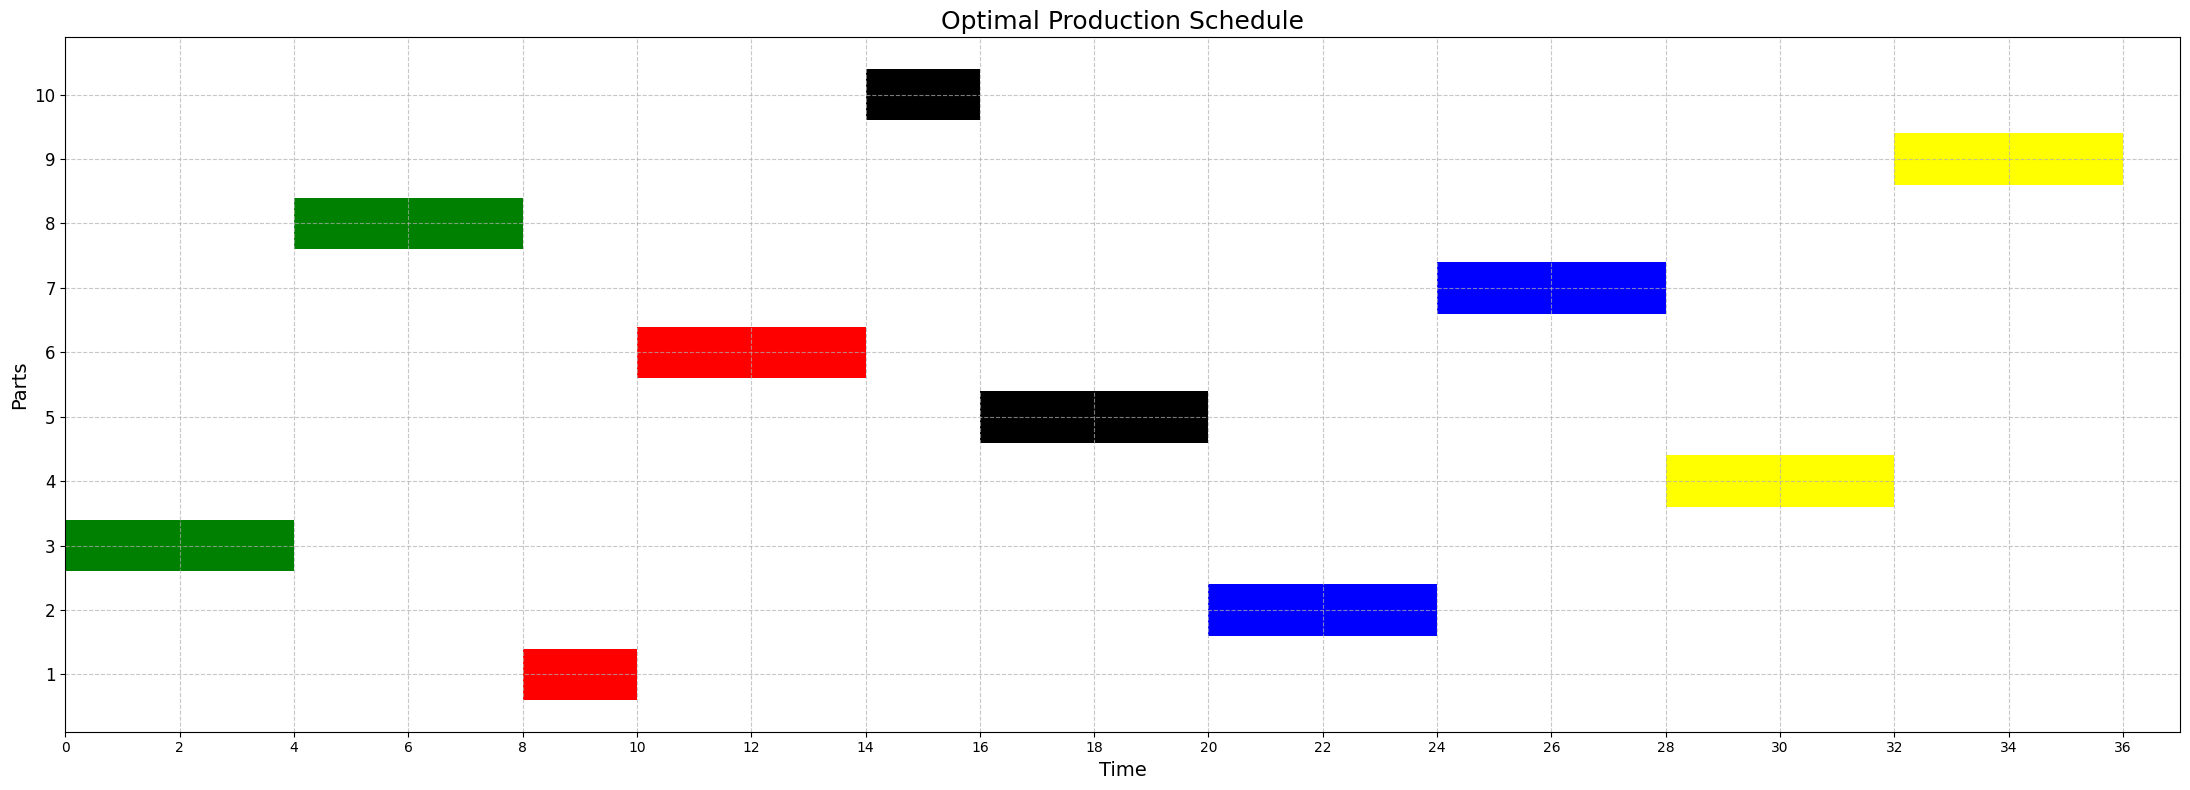

Minimized Total Cost (Objective Value): 27.0


In [16]:
if model.status == GRB.OPTIMAL:
    print("Optimal solution found:")

    # Extract start and end times for each part
    start_times_values = [start_times[p].X for p in range(1, num_parts + 1)]
    end_times_values = [end_times[p].X for p in range(1, num_parts + 1)]

    # Plotting the Gantt chart
    plt.figure(figsize=(22, 8))
    
    # Define color mapping for the parts
    color_map = {
        'Red': 'red',
        'Blue': 'blue',
        'Green': 'green',
        'Yellow': 'yellow',
        'Black': 'black',
    }
    
    # Store unique colors for legend
    used_colors = set()

    # Plot bars without repetitive labels
    for p in range(1, num_parts + 1):
        part_color = color_map[parts_colors[p]]
        plt.barh(p, end_times_values[p-1] - start_times_values[p-1], 
                 left=start_times_values[p-1], color=part_color)
        
        # Add unique color label only once
        if parts_colors[p] not in used_colors:
            used_colors.add(parts_colors[p])
            plt.barh(p, end_times_values[p-1] - start_times_values[p-1], 
                     left=start_times_values[p-1], color=part_color, 
                     label=parts_colors[p])

    # Enhanced plot details
    plt.title("Optimal Production Schedule", fontsize=18)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Parts", fontsize=14)
    plt.xticks(np.arange(0, max(end_times_values) + 1, 2))  # Adjust tick intervals
    plt.yticks(range(1, num_parts + 1), fontsize=12)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.xlim(0, max(end_times_values) + 1)  # Provide padding on x-axis
    plt.tight_layout()

    plt.show()

    # Display objective function result
    minimized_cost = model.ObjVal
    print(f"Minimized Total Cost (Objective Value): {minimized_cost}")

else:
    print("No optimal solution found.")